In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection
from scipy.signal import butter,filtfilt,iirnotch
#from PyEMD import EMD
#import wandb
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocessing

In [2]:
#get emg and restimulus as tensors (E2 files only)
emg_S1 = torch.tensor(((pd.read_csv('./NinaproDB5/s1/emgS1_E2.csv')).to_numpy()), dtype=torch.float32)
restimulus_S1 = torch.tensor((pd.read_csv('./NinaproDB5/s1/restimulusS1_E2.csv')).to_numpy(), dtype=torch.float32)
emg_S2 = torch.tensor(((pd.read_csv('./NinaproDB5/s2/emgS2_E2.csv')).to_numpy()), dtype=torch.float32)
restimulus_S2 = torch.tensor((pd.read_csv('./NinaproDB5/s2/restimulusS2_E2.csv')).to_numpy(), dtype=torch.float32)
emg_S3 = torch.tensor(((pd.read_csv('./NinaproDB5/s3/emgS3_E2.csv')).to_numpy()), dtype=torch.float32)
restimulus_S3 = torch.tensor((pd.read_csv('./NinaproDB5/s3/restimulusS3_E2.csv')).to_numpy(), dtype=torch.float32)
emg_S4 = torch.tensor(((pd.read_csv('./NinaproDB5/s4/emgS4_E2.csv')).to_numpy()), dtype=torch.float32)
restimulus_S4 = torch.tensor((pd.read_csv('./NinaproDB5/s4/restimulusS4_E2.csv')).to_numpy(), dtype=torch.float32)
emg_S5 = torch.tensor(((pd.read_csv('./NinaproDB5/s5/emgS5_E2.csv')).to_numpy()), dtype=torch.float32)
restimulus_S5 = torch.tensor((pd.read_csv('./NinaproDB5/s5/restimulusS5_E2.csv')).to_numpy(), dtype=torch.float32)
emg_S6 = torch.tensor(((pd.read_csv('./NinaproDB5/s6/emgS6_E2.csv')).to_numpy()), dtype=torch.float32)
restimulus_S6 = torch.tensor((pd.read_csv('./NinaproDB5/s6/restimulusS6_E2.csv')).to_numpy(), dtype=torch.float32)
emg_S7 = torch.tensor(((pd.read_csv('./NinaproDB5/s7/emgS7_E2.csv')).to_numpy()), dtype=torch.float32)
restimulus_S7 = torch.tensor((pd.read_csv('./NinaproDB5/s7/restimulusS7_E2.csv')).to_numpy(), dtype=torch.float32)
emg_S8 = torch.tensor(((pd.read_csv('./NinaproDB5/s8/emgS8_E2.csv')).to_numpy()), dtype=torch.float32)
restimulus_S8 = torch.tensor((pd.read_csv('./NinaproDB5/s8/restimulusS8_E2.csv')).to_numpy(), dtype=torch.float32)
emg_S9 = torch.tensor(((pd.read_csv('./NinaproDB5/s9/emgS9_E2.csv')).to_numpy()), dtype=torch.float32)
restimulus_S9 = torch.tensor((pd.read_csv('./NinaproDB5/s9/restimulusS9_E2.csv')).to_numpy(), dtype=torch.float32)
emg_S10 = torch.tensor(((pd.read_csv('./NinaproDB5/s10/emgS10_E2.csv')).to_numpy()), dtype=torch.float32)
restimulus_S10 = torch.tensor((pd.read_csv('./NinaproDB5/s10/restimulusS10_E2.csv')).to_numpy(), dtype=torch.float32)

# windowing
wLen = 250 #ms
#wLen = 500 #ms
#stepLen = int(wLen/25) 
stepLen = 10 #50 ms
def balance (restimulus):
    numZero = 0
    indices = []
    #print(restimulus.shape)
    for x in range (len(restimulus)):
        L = torch.chunk(restimulus[x], 2, dim=1)
        if torch.equal(L[0], L[1]):
            if L[0][0][0] == 0:
                if (numZero < 380):
                    #print("working")
                    indices += [x]
                numZero += 1
            else:
                indices += [x]
    return indices

def contract(R):
    labels = torch.tensor(())
    labels = labels.new_zeros(size=(len(R), 18))
    for x in range(len(R)):
        labels[x][int(R[x][0][0])] = 1.0
    return labels

def filter(emg):
    # sixth-order Butterworth highpass filter
    b, a = butter(N=3, Wn=5, btype='highpass', analog=False, fs=200.0)
    emgButter = torch.from_numpy(np.flip(filtfilt(b, a, emg),axis=0).copy())

    #second-order notch filter at 50 Hz
    b, a = iirnotch(w0=50.0, Q=0.0001, fs=200.0)
    return torch.from_numpy(np.flip(filtfilt(b, a, emgButter),axis=0).copy())

restimulus_S1 = restimulus_S1.unfold(dimension=0, size=int(wLen / 5), step=stepLen)
restimulus_S2 = restimulus_S2.unfold(dimension=0, size=int(wLen / 5), step=stepLen)
restimulus_S3 = restimulus_S3.unfold(dimension=0, size=int(wLen / 5), step=stepLen)
restimulus_S4 = restimulus_S4.unfold(dimension=0, size=int(wLen / 5), step=stepLen)
restimulus_S5 = restimulus_S5.unfold(dimension=0, size=int(wLen / 5), step=stepLen)
restimulus_S6 = restimulus_S6.unfold(dimension=0, size=int(wLen / 5), step=stepLen)
restimulus_S7 = restimulus_S7.unfold(dimension=0, size=int(wLen / 5), step=stepLen)
restimulus_S8 = restimulus_S8.unfold(dimension=0, size=int(wLen / 5), step=stepLen)
restimulus_S9 = restimulus_S9.unfold(dimension=0, size=int(wLen / 5), step=stepLen)
restimulus_S10 = restimulus_S10.unfold(dimension=0, size=int(wLen / 5), step=stepLen)

emg_S1 = filter(emg_S1.unfold(dimension=0, size=int(wLen / 5), step=10)[balance(restimulus_S1)])
emg_S2 = filter(emg_S2.unfold(dimension=0, size=int(wLen / 5), step=10)[balance(restimulus_S2)])
emg_S3 = filter(emg_S3.unfold(dimension=0, size=int(wLen / 5), step=10)[balance(restimulus_S3)])
emg_S4 = filter(emg_S4.unfold(dimension=0, size=int(wLen / 5), step=10)[balance(restimulus_S4)])
emg_S5 = filter(emg_S5.unfold(dimension=0, size=int(wLen / 5), step=10)[balance(restimulus_S5)])
emg_S6 = filter(emg_S6.unfold(dimension=0, size=int(wLen / 5), step=10)[balance(restimulus_S6)])
emg_S7 = filter(emg_S7.unfold(dimension=0, size=int(wLen / 5), step=10)[balance(restimulus_S7)])
emg_S8 = filter(emg_S8.unfold(dimension=0, size=int(wLen / 5), step=10)[balance(restimulus_S8)])
emg_S9 = filter(emg_S9.unfold(dimension=0, size=int(wLen / 5), step=10)[balance(restimulus_S9)])
emg_S10 = filter(emg_S10.unfold(dimension=0, size=int(wLen / 5), step=10)[balance(restimulus_S10)])
labels_S1 = contract(restimulus_S1[balance(restimulus_S1)])
labels_S2 = contract(restimulus_S2[balance(restimulus_S2)])
labels_S3 = contract(restimulus_S3[balance(restimulus_S3)])
labels_S4 = contract(restimulus_S4[balance(restimulus_S4)])
labels_S5 = contract(restimulus_S5[balance(restimulus_S5)])
labels_S6 = contract(restimulus_S6[balance(restimulus_S6)])
labels_S7 = contract(restimulus_S7[balance(restimulus_S7)])
labels_S8 = contract(restimulus_S8[balance(restimulus_S8)])
labels_S9 = contract(restimulus_S9[balance(restimulus_S9)])
labels_S10 = contract(restimulus_S10[balance(restimulus_S10)])
emg = [emg_S1, emg_S2, emg_S3, emg_S4, emg_S5, emg_S6, emg_S7, emg_S8, emg_S9, emg_S10]
labels = [labels_S1, labels_S2, labels_S3, labels_S4, labels_S5, labels_S6, labels_S7, labels_S8, labels_S9, labels_S10]

length = len(emg[0][0])
width = len(emg[0][0][0])
print(length)
print(width)

emg_in = np.concatenate([np.array(i.view(len(i), length*width)) for i in emg], axis=0, dtype=np.float16)
s = preprocessing.StandardScaler().fit(emg_in)
del emg_in

cmap = mpl.colormaps['viridis']
#cmap = mpl.colormaps['jet']

def getImages (emg):
    allImages = []
    emg = s.transform(np.array(emg.view(len(emg), length*width)))
    
    for i in range (len(emg)):
        data = emg[i] - min(emg[i])
        data = data / max(data)
        data = torch.from_numpy(data).view(length, width).to(torch.float32)
        
        imageL = np.zeros((3, length, width//2))
        imageR = np.zeros((3, length, width//2))
        for p in range (length):
            for q in range (width//2):
                imageL[:, p, q] = (cmap(float(data[p][q])))[:3]
                imageR[:, p, q] = (cmap(float(data[p][q+width//2])))[:3]
        
        imageL = transforms.Resize([96, 100], interpolation=transforms.InterpolationMode.BICUBIC, antialias=True)(torch.from_numpy(imageL))
        imageR = transforms.Resize([96, 100], interpolation=transforms.InterpolationMode.BICUBIC, antialias=True)(torch.from_numpy(imageR))
        imageL = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(imageL)
        imageR = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(imageR)

        allImages.append(torch.cat([imageL, imageR], dim=2).numpy().astype(np.float32))

        '''
        if i % 1000 == 0:
            print("progress: " + str(i) + "/" + str(len(emg)))
            #print(labels[0][i])
        #if (i % 5000 == 4999):
            plt.imshow(allImages[i].T, origin='lower')
            plt.axis('off')
            plt.show()
        '''
    return allImages

'''
for i in range (10):
#i = 1
    file_path = "./NinaproDB5/rawImages_" + str(i+1) + ".npy"
    data = getImages(emg[i])
    np.save(file_path, data)
    file_path = "./NinaproDB5/label_" + str(i+1) + ".npy"
    np.save(file_path, labels[i])
'''
with  multiprocessing.Pool(processes=10) as pool:
    data_async = pool.map_async(getImages, [(emg[i]) for i in range(len(emg))])
    data = data_async.get()

'''
loc = 1
image = data[loc].T
plt.imshow(image, origin='lower')
plt.axis('off')
plt.show()
'''

16
50


KeyboardInterrupt: 

In [ ]:
leaveOut = False
combined_labels = np.concatenate([np.array(i) for i in labels], axis=0, dtype=np.float16)
combined_images = np.concatenate([np.array(i) for i in data], axis=0, dtype=np.float16)

X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(combined_images, combined_labels, test_size=0.2)
if leaveOut:
    X_test = outEMG
    Y_test = outLabels
else:
    X_validation, X_test, Y_validation, Y_test = model_selection.train_test_split(X_validation, Y_validation, test_size=0.5)

X_train = torch.from_numpy(X_train).to(torch.float32)
Y_train = torch.from_numpy(Y_train).to(torch.float32)
X_validation = torch.from_numpy(X_validation).to(torch.float32)
Y_validation = torch.from_numpy(Y_validation).to(torch.float32)
X_test = torch.from_numpy(X_test).to(torch.float32)
Y_test = torch.from_numpy(Y_test).to(torch.float32)
print(X_train.size())
print(X_validation.size())
print(X_test.size())

torch.Size([58710, 3, 96, 200])
torch.Size([7339, 3, 96, 200])
torch.Size([7339, 3, 96, 200])


In [ ]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-2])
#model = nn.Sequential(*list(model.children())[:-4])
num_features = model[-1][-1].conv3.out_channels
#num_features = model.fc.in_features
dropout = 0.5
model.add_module('avgpool', nn.AdaptiveAvgPool2d(1))
model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(num_features, 1024))
model.add_module('relu', nn.ReLU())
model.add_module('dropout1', nn.Dropout(dropout))
model.add_module('fc2', nn.Linear(1024, 1024))
model.add_module('relu2', nn.ReLU())
model.add_module('dropout2', nn.Dropout(dropout))
model.add_module('fc3', nn.Linear(1024, 18))
model.add_module('softmax', nn.Softmax(dim=1))

num = 0
for name, param in model.named_parameters():
    num += 1
    if (num > 0):
    #if (num > 72): # for -3
    #if (num > 33): # for -4
        param.requires_grad = True
    else:
        param.requires_grad = False

class Data(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

batch_size = 64
train_loader = DataLoader(list(zip(X_train, Y_train)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(list(zip(X_validation, Y_validation)), batch_size=batch_size)
test_loader = DataLoader(list(zip(X_test, Y_test)), batch_size=batch_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
learn = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learn)

cuda
Epoch 1/75 | Train Loss: 2.7454 | Val Loss: 2.6135
Train Accuracy: 0.2207 | Val Accuracy: 0.3671
Epoch 2/75 | Train Loss: 2.5448 | Val Loss: 2.4948
Train Accuracy: 0.4349 | Val Accuracy: 0.4824
Epoch 3/75 | Train Loss: 2.4595 | Val Loss: 2.4404
Train Accuracy: 0.5217 | Val Accuracy: 0.5403
Epoch 4/75 | Train Loss: 2.4076 | Val Loss: 2.3980
Train Accuracy: 0.5738 | Val Accuracy: 0.5840
Epoch 5/75 | Train Loss: 2.3412 | Val Loss: 2.3373
Train Accuracy: 0.6410 | Val Accuracy: 0.6434
Epoch 6/75 | Train Loss: 2.2909 | Val Loss: 2.3038
Train Accuracy: 0.6908 | Val Accuracy: 0.6763
Epoch 7/75 | Train Loss: 2.2570 | Val Loss: 2.2868
Train Accuracy: 0.7251 | Val Accuracy: 0.6949
Epoch 8/75 | Train Loss: 2.2338 | Val Loss: 2.2555
Train Accuracy: 0.7486 | Val Accuracy: 0.7252
Epoch 9/75 | Train Loss: 2.2080 | Val Loss: 2.2383
Train Accuracy: 0.7741 | Val Accuracy: 0.7426
Epoch 10/75 | Train Loss: 2.1883 | Val Loss: 2.2263
Train Accuracy: 0.7937 | Val Accuracy: 0.7560
Epoch 11/75 | Train Loss

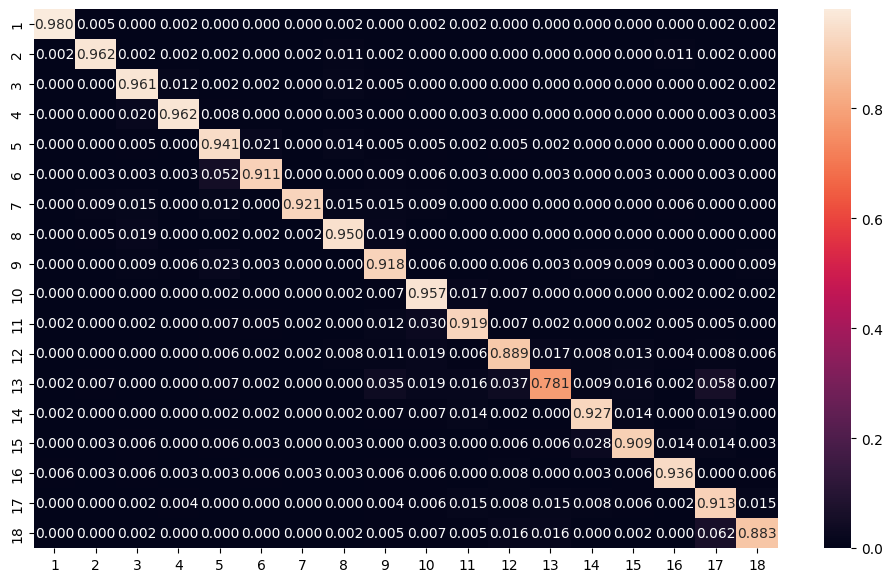

In [ ]:
# Training loop
import gc
gc.collect()
torch.cuda.empty_cache()

#run = wandb.init(name='CNN', project='emg_benchmarking', entity='msoh')
#wandb.config.lr = learn

num_epochs = 75
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

#wandb.watch(model)

for epoch in range(num_epochs):
    model.train()
    train_acc = 0.0
    train_loss = 0.0
    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, Y_batch)
        train_loss += loss.item()

        train_acc += np.mean(np.argmax(output.cpu().detach().numpy(), 
                                       axis=1) == np.argmax(Y_batch.cpu().detach().numpy(), axis=1))

        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            output = model(X_batch)
            val_loss += criterion(output, Y_batch).item()

            val_acc += np.mean(np.argmax(output.cpu().detach().numpy(), axis=1) == np.argmax(Y_batch.cpu().detach().numpy(), axis=1))

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Accuracy: {train_acc:.4f} | Val Accuracy: {val_acc:.4f}")

    '''
    wandb.log({
        "Epoch": epoch,
        "Train Loss": train_loss,
        "Train Acc": train_acc,
        "Valid Loss": val_loss,
        "Valid Acc": val_acc})
    
run.finish()
'''
# %%
# Testing
pred = []
true = []

model.eval()
test_loss = 0.0
test_acc = 0.0
with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        output = model(X_batch)
        test_loss += criterion(output, Y_batch).item()

        test_acc += np.mean(np.argmax(output.cpu().detach().numpy(), axis=1) == np.argmax(Y_batch.cpu().detach().numpy(), axis=1))

        output = np.argmax(output.cpu().detach().numpy(), axis=1)
        pred.extend(output)
        labels = np.argmax(Y_batch.cpu().detach().numpy(), axis=1)
        true.extend(labels)

test_loss /= len(test_loader)
test_acc /= len(test_loader)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

cf_matrix = confusion_matrix(true, pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = np.arange(1, 19, 1),
                     columns = np.arange(1, 19, 1))
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True, fmt=".3f")
plt.savefig('output.png')